<a href="https://colab.research.google.com/github/kokchun/Deep-learning-AI21/blob/main/Lectures/Lec0.1-MLP_classification.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; for interacting with the code


---
# Lecture notes - Multilayered perceptron (MLP) for classification
---

This is the lecture note for **MLP** and its use in classification task.

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to MLP. I encourage you to read further about MLP. </p>

Read more:

- [How many nodes and layers? - DigitalSreeni](https://www.youtube.com/watch?v=bqBRET7tbiQ)
- [Adam optimizer - wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)
- [Cross-entropy - wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)
- [Cross-entropy - machinelearningmastery](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)
- [None in model - stackoverflow](https://stackoverflow.com/questions/47240348/what-is-the-meaning-of-the-none-in-model-summary-of-keras)
- [EarlyStopping - Keras](https://keras.io/api/callbacks/early_stopping/)
- [Adam optimization algorithm - Andrew Ng](https://www.youtube.com/watch?v=JXQT_vxqwIs)
---

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer

plt.style.use("seaborn-white")
raw_data = load_breast_cancer()
X, y = raw_data.data, raw_data.target

# skipping the EDA for this dataset, as we have already worked with it before
# just checking if there is any null values and sizes
print(np.isnan(X).any())
print(X.shape, y.shape)

False
(569, 30) (569,)


---
## Train|val|test split and scaling

Note that for this dataset, as it is small be smart to use $k$-fold cross-validation for hyperparameter tuning, but I go with train|val|test split for simplicity of the lecture

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# note that scaling is very important for gradient descent to properly work
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# note no data leakage
scaled_X_train_val = scaler.fit_transform(X_train_val)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

# note that this one will be used in the end and thus can use all training data for scaling
scaled_X_train = scaler.fit_transform(X_train)

print("X_train, X_val, X_test")
scaled_X_train_val.shape, scaled_X_val.shape, scaled_X_test.shape

X_train, X_val, X_test


((410, 30), (73, 30), (86, 30))

--- 
## MLP network

An multilayered perceptron (MLP) network is deep, if it has ≥2 hidden layers. It is a feedforward network, which means that the input is going forward into next layer, which is moving forward to its next layer and so on until we get an output. Basically one hidden layer is enough for a network to approximate any continous function by carving up the input space with many linear functions. However by adding more hidden layers we get function compositions, i.e. functions of other functions, which easier can represent more advanced structures of the data.

Unfortunately there is no mathematical formula that tells us how many nodes and hidden layers to use. In short, the best we can do is by trial and error. There are however some methods for building networks, as we can test on validation data: 

- grow a network from nothing, slowly adding nodes and layers
- pruning - start from a large network and remove nodes and layers
- global search - use a genetic algorithm to test out several network configurations
- regularization - keep the network small by constraining the magnitude of the weights  
- early stopping - the more the network trains the better it gets at fitting the training data, so we can stop it before it starts to overfit 

The idea is to have a network that is complex enough to fit the training data and not too complex such that it overfits it and generalizes badly within its coverage regions. 

---
### Binary cross-entropy loss function 

The loss function we will use for the binary classification problem is the binary cross-entropy. This loss function $\mathcal{L}$ is basically a measure of how different two probability distributions are from each other for a random variable. As we can view the response (target) variable $y$ and the predicted variable $\hat{y}$ as a probability distributions, we can see how different they are from each other and penalize this difference in gradient descent. 

$$\mathcal{L} = -\frac{1}{n}\sum_{i = 1}^n{y_i\ln{\hat{y}_i}} + (1-y_i)\ln{(1-\hat{y}_i)}$$



In [4]:
X.shape[1]

30

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense

def MLP_model():
    model = Sequential(name = "MLP_initial")
    model.add(InputLayer(X.shape[1], name = "Input_layer"))
    model.add(Dense(30, name = "Hidden_layer1", activation="relu"))
    model.add(Dense(30, name = "Hidden_layer2", activation="relu"))
    # binary cross-entropy 
    model.add(Dense(1, name = "Output_layer", activation="sigmoid"))

    # adam is a type of stochastic gradient descent
    model.compile(loss ="binary_crossentropy", optimizer="adam")

    return model

model = MLP_model()
# the output shape None means the batch size and is automatically defined in fit or predict
# number of trainable params  (30+1)*30 + (30+1)*30+31 = 1891
model.summary()

Model: "MLP_initial"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer1 (Dense)       (None, 30)                930       
                                                                 
 Hidden_layer2 (Dense)       (None, 30)                930       
                                                                 
 Output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [6]:
# we train it very long to observe overfitting
model.fit(scaled_X_train_val, y_train_val, epochs = 1000, validation_data=(scaled_X_val, y_val), verbose = 0)

<AxesSubplot:title={'center':'Training and validation loss'}, xlabel='Epochs', ylabel='Cross-entropy loss'>

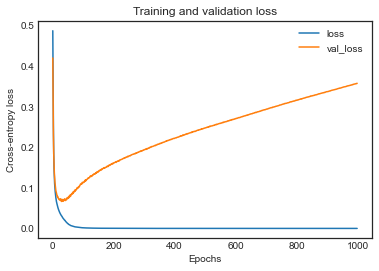

In [7]:
import pandas as pd
pd.DataFrame(model.history.history).plot(xlabel="Epochs",
                                         ylabel="Cross-entropy loss", title="Training and validation loss")
# clearly see overfitting here as the validation loss increases, while training loss decreases
# this means the model can't generalize to data it hasn't seen
# actually our model seems to overfit very early, indicating that we need to have a less complex model

---
## Early stopping

We can simple choose to stop the model before the validation loss increases. This is basically a free lunch.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# don't stop immediately -> stop after 15
# min mode -> stop when quantity monitored stopped decreasing
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=15)

# note that we have to redefine the model, else it will continue training on the previous model
model = MLP_model()

# note that the callbacks accept a list of callback functions that will run during the training
model.fit(scaled_X_train_val, y_train_val, epochs=1000,
          validation_data=[scaled_X_val, y_val], callbacks=[early_stopper], verbose=1)


Epoch 1/1000
13/13 [==============================] - 1s 14ms/step - loss: 0.5441 - val_loss: 0.4385
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3634 - val_loss: 0.3062
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2595 - val_loss: 0.2324
Epoch 4/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.1997 - val_loss: 0.1899
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1650 - val_loss: 0.1615
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1404 - val_loss: 0.1411
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1234 - val_loss: 0.1259
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1091 - val_loss: 0.1130
Epoch 9/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0982 - val_loss: 0.1020
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0891 - val_loss: 0.092

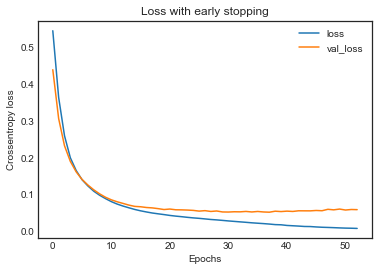

In [9]:
# this is much better
df_loss = pd.DataFrame(model.history.history)
df_loss.plot(xlabel="Epochs",
             ylabel="Crossentropy loss", title="Loss with early stopping");

# To improve on this we should simplify the network more to get validation loss closer to training loss.
# I will let you explore this yourself


In [12]:
df_loss

,loss,val_loss
0,0.544142,0.438516
1,0.363404,0.306221
2,0.259534,0.232409
3,0.199739,0.189851
4,0.165016,0.161548
5,0.140367,0.141055
6,0.123378,0.125865
7,0.109121,0.112957
8,0.098219,0.102041
9,0.089133,0.092864


---
## Prediction and evaluation

- note that we changed the number of epochs, which is a hyperparameter tuning
- we did this on the validation data which is okay, we don't have data leakage
- before prediction we will utilize all training data, i.e. training and evaluation
- then predict on test data

In [11]:
len(df_loss)

53

(483, 30) (483,) (483, 1)
[[9.7804725e-01]
 [1.1508621e-06]
 [6.8902969e-04]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.96      1.00      0.98        54

    accuracy                           0.98        86
   macro avg       0.98      0.97      0.97        86
weighted avg       0.98      0.98      0.98        86



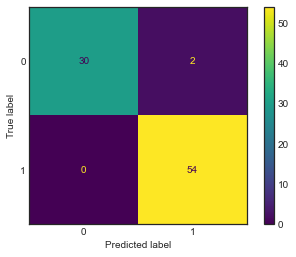

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
model = MLP_model()

# model fit needs to have same shapes 
print(scaled_X_train.shape, y_train.shape, y_train[:,None].shape)

model.fit(scaled_X_train, y_train[:,None], epochs=len(df_loss),
          validation_data=[scaled_X_test, y_test], callbacks=[early_stopper], verbose=0)

final_loss = pd.DataFrame(model.history.history)

y_pred = model.predict(scaled_X_test)
print(y_pred[:3]) # probabilities due to sigmoid activation function

y_pred = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_test, y_pred))